In [1]:
# =========================
# Cell 1: Setup and Imports
# =========================
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time

torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
# =========================
# Cell 2: Network Definition
# =========================
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 100), nn.Tanh(),
            nn.Linear(100, 100), nn.Tanh(),
            nn.Linear(100, 100), nn.Tanh(),
            nn.Linear(100, 100), nn.Tanh(),
            nn.Linear(100, 1)
        )
    def forward(self, x):
        return self.layers(x)

model = Net().to(device)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)
model.apply(init_weights)

Net(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Tanh()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): Tanh()
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [3]:
# =============================
# Cell 3: Exact Solution & RHS
# =============================
def exact_solution(x):
    return (1/(2*np.pi**2)) * torch.sin(np.pi*x[:,0]) * torch.sin(np.pi*x[:,1])

def rhs_f(x):
    return (np.pi**4 / 2) * torch.sin(np.pi*x[:,0]) * torch.sin(np.pi*x[:,1])

def dirichlet_bc(x):
    return exact_solution(x)

In [4]:
# ==============================================
# Cell 4: Collocation and Boundary Point Sampler
# ==============================================
N_int, N_bd = 8000, 2000
def get_interior(N):
    return torch.rand(N, 2, device=device)

def get_boundary(M):
    grid = torch.linspace(0, 1, M//4, device=device)
    pts = [
        torch.stack([grid, torch.zeros_like(grid)], dim=1),
        torch.stack([grid, torch.ones_like(grid)], dim=1),
        torch.stack([torch.zeros_like(grid), grid], dim=1),
        torch.stack([torch.ones_like(grid), grid], dim=1)
    ]
    return torch.cat(pts, dim=0)

In [5]:
# =================================
# Cell 5: Improved Loss Functional
# =================================
def biharmonic_loss(model, x_int, x_bd, bc_weight=10000.0):
    # Interior loss: Biharmonic equation residual
    x_int.requires_grad_()
    u = model(x_int)

    # First derivatives
    grad_u = torch.autograd.grad(u, x_int, grad_outputs=torch.ones_like(u),
                                create_graph=True, retain_graph=True)[0]

    # Second derivatives (Laplacian)
    lap_u = torch.zeros_like(u.squeeze())
    for i in range(2):
        grad_ui = torch.autograd.grad(grad_u[:, i], x_int,
                                     grad_outputs=torch.ones_like(grad_u[:, i]),
                                     create_graph=True, retain_graph=True)[0][:, i]
        lap_u += grad_ui

    # Third derivatives
    grad_lap = torch.autograd.grad(lap_u, x_int,
                                  grad_outputs=torch.ones_like(lap_u),
                                  create_graph=True, retain_graph=True)[0]

    # Fourth derivatives (Bilaplacian)
    biharmonic = torch.zeros_like(lap_u)
    for i in range(2):
        biharmonic += torch.autograd.grad(grad_lap[:, i], x_int,
                                        grad_outputs=torch.ones_like(grad_lap[:, i]),
                                        create_graph=True)[0][:, i]

    f = rhs_f(x_int)
    pde_residual = (biharmonic - f)**2
    pde_loss = pde_residual.mean()

    # Boundary loss
    u_bd = model(x_bd)
    bc_loss = ((u_bd.squeeze() - dirichlet_bc(x_bd))**2).mean()

    total_loss = pde_loss + bc_weight * bc_loss
    return total_loss


In [7]:
# =============================
# Cell 6: Training Configuration
# =============================
epochs = 20000
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                      factor=0.5, patience=500)
losses = []
start_time = time.time()

print("Starting training...")
for epoch in range(epochs):
    model.train()
    x_int, x_bd = get_interior(N_int), get_boundary(N_bd)
    loss = biharmonic_loss(model, x_int, x_bd, bc_weight=10000.0)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step(loss)

    losses.append(loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss {loss.item():.6e}, LR: {scheduler.optimizer.param_groups[0]['lr']:.2e}")

# Final LBFGS optimization
print("Starting LBFGS fine-tuning...")
lbfgs_optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, max_iter=1000,
                                   tolerance_grad=1e-8, tolerance_change=1e-10,
                                   history_size=100)

def closure():
    lbfgs_optimizer.zero_grad()
    x_int, x_bd = get_interior(N_int), get_boundary(N_bd)
    loss = biharmonic_loss(model, x_int, x_bd, bc_weight=10000.0)
    loss.backward()
    return loss

lbfgs_optimizer.step(closure)

Starting training...


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:1340: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  current = float(metrics)


Epoch 0: Loss 5.832956e+02, LR: 1.00e-03
Epoch 500: Loss 9.323421e+00, LR: 1.00e-03
Epoch 1000: Loss 2.550079e+00, LR: 1.00e-03
Epoch 1500: Loss 1.489399e+00, LR: 1.00e-03
Epoch 2000: Loss 2.448847e+00, LR: 1.00e-03
Epoch 2500: Loss 4.215959e+00, LR: 1.00e-03
Epoch 3000: Loss 2.298252e+00, LR: 5.00e-04
Epoch 3500: Loss 3.088857e-01, LR: 5.00e-04
Epoch 4000: Loss 8.361424e-02, LR: 2.50e-04
Epoch 4500: Loss 3.598086e-02, LR: 1.25e-04
Epoch 5000: Loss 1.265586e-02, LR: 6.25e-05
Epoch 5500: Loss 8.593166e-03, LR: 3.13e-05
Epoch 6000: Loss 7.991687e-03, LR: 3.13e-05
Epoch 6500: Loss 7.423477e-03, LR: 3.13e-05
Epoch 7000: Loss 7.058636e-03, LR: 3.13e-05
Epoch 7500: Loss 5.951594e-03, LR: 3.13e-05
Epoch 8000: Loss 5.233988e-03, LR: 3.13e-05
Epoch 8500: Loss 5.172760e-03, LR: 3.13e-05
Epoch 9000: Loss 9.672327e-03, LR: 3.13e-05
Epoch 9500: Loss 4.582169e-03, LR: 3.13e-05
Epoch 10000: Loss 3.397700e-03, LR: 1.56e-05
Epoch 10500: Loss 3.238420e-03, LR: 1.56e-05
Epoch 11000: Loss 3.302198e-03, LR

tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)

In [8]:
# ===================
# Cell 7: Save Output
# ===================
torch.save(model.state_dict(), "improved_biharmonic_model.pt")

In [9]:
# =============================
# Cell 8: Print Architecture, Stats
# =============================
train_time = time.time() - start_time
print(f"\n=== TRAINING SUMMARY ===")
print(f"Training time: {train_time:.2f} seconds")
print("Neural Network Architecture:")
print(model)
n_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {n_params}")
print(f"Non-zero parameters: {sum(torch.count_nonzero(p).item() for p in model.parameters())}")
print(f"Adam initial lr: 1e-3, LBFGS steps: 1000")
print(f"Interior points: {N_int}, Boundary points: {N_bd}")
print(f"Boundary penalty weight: {10000.0}")
print(f"Final training loss: {losses[-1]:.6e}")



=== TRAINING SUMMARY ===
Training time: 13718.28 seconds
Neural Network Architecture:
Net(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Tanh()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): Tanh()
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)
Total parameters: 30701
Non-zero parameters: 30701
Adam initial lr: 1e-3, LBFGS steps: 1000
Interior points: 8000, Boundary points: 2000
Boundary penalty weight: 10000.0
Final training loss: 1.886185e-03



Generating plots...


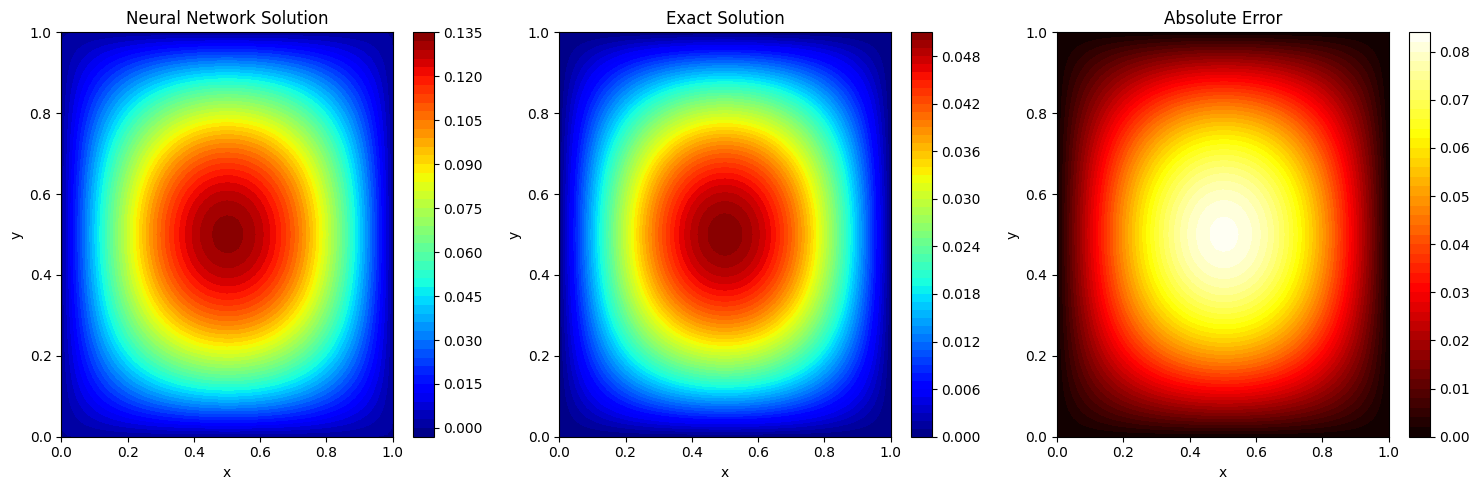

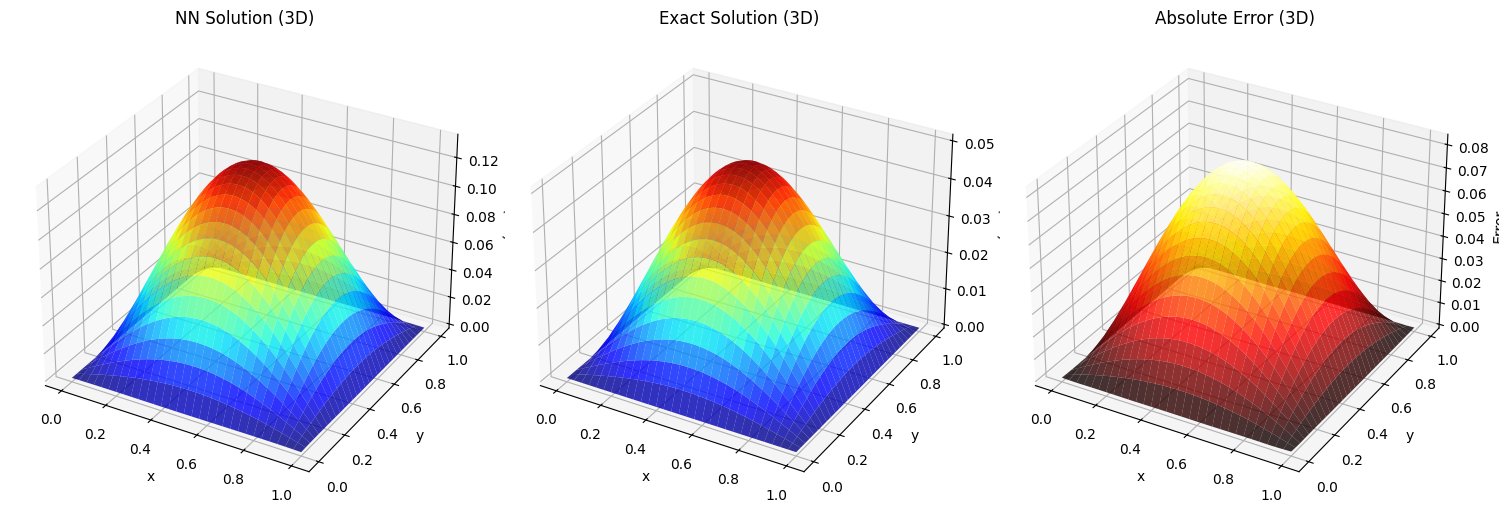

In [10]:
# ===================================
# Cell 9: Plot Solutions and Error
# ===================================
print("\nGenerating plots...")
gsize = 61
xg = np.linspace(0, 1, gsize)
X, Y = np.meshgrid(xg, xg)
grid_points = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=-1),
                          device=device, dtype=torch.float64)

model.eval()
with torch.no_grad():
    u_nn = model(grid_points).cpu().numpy().reshape(gsize, gsize)
    u_gt = exact_solution(grid_points).cpu().numpy().reshape(gsize, gsize)
    err = np.abs(u_nn - u_gt)

# Neural Network Solution
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.contourf(X, Y, u_nn, levels=50, cmap='jet')
plt.colorbar()
plt.title('Neural Network Solution')
plt.xlabel('x')
plt.ylabel('y')

# Exact Solution
plt.subplot(132)
plt.contourf(X, Y, u_gt, levels=50, cmap='jet')
plt.colorbar()
plt.title('Exact Solution')
plt.xlabel('x')
plt.ylabel('y')

# Absolute Error
plt.subplot(133)
err_plot = plt.contourf(X, Y, err, levels=50, cmap='hot')
plt.colorbar(err_plot)
plt.title('Absolute Error')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.savefig("solutions_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# 3D Plots
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X, Y, u_nn, cmap='jet', alpha=0.8)
ax1.set_title('NN Solution (3D)')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('u(x,y)')

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X, Y, u_gt, cmap='jet', alpha=0.8)
ax2.set_title('Exact Solution (3D)')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('u(x,y)')

ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X, Y, err, cmap='hot', alpha=0.8)
ax3.set_title('Absolute Error (3D)')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('Error')

plt.tight_layout()
plt.savefig("3d_solutions.png", dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# ==================================
# Cell 10: Error Metrics Calculation
# ==================================
print("\nComputing error metrics...")
grid_points.requires_grad = True

# Compute solutions and gradients
u_gt_val = exact_solution(grid_points)
u_nn_val = model(grid_points)

# First derivatives
u_gt_grad = torch.autograd.grad(u_gt_val, grid_points, torch.ones_like(u_gt_val),
                               create_graph=True)[0]
u_nn_grad = torch.autograd.grad(u_nn_val, grid_points, torch.ones_like(u_nn_val),
                               create_graph=True)[0]

# Second derivatives
H_gt = []
H_nn = []
for i in range(2):
    H_gt_i = torch.autograd.grad(u_gt_grad[:, i], grid_points,
                                torch.ones_like(u_gt_grad[:, i]),
                                create_graph=True)[0][:, i]
    H_nn_i = torch.autograd.grad(u_nn_grad[:, i], grid_points,
                                torch.ones_like(u_nn_grad[:, i]),
                                create_graph=True)[0][:, i]
    H_gt.append(H_gt_i.detach().cpu().numpy())
    H_nn.append(H_nn_i.detach().cpu().numpy())

# Convert to numpy for error computation
u_gt_np = u_gt_val.detach().cpu().numpy().ravel()
u_nn_np = u_nn_val.detach().cpu().numpy().ravel()
u_gt_grad_np = u_gt_grad.detach().cpu().numpy()
u_nn_grad_np = u_nn_grad.detach().cpu().numpy()

# Error computation functions
def L2_norm(u):
    return np.sqrt(np.mean(u**2))

def H1_norm(u, grad):
    return np.sqrt(np.mean(u**2) + np.mean(grad[:,0]**2 + grad[:,1]**2))

def H2_norm(u, grad, H):
    return np.sqrt(np.mean(u**2) + np.mean(grad[:,0]**2 + grad[:,1]**2) +
                  np.mean(H[0]**2 + H[1]**2))

# Compute errors
L2_err = L2_norm(u_gt_np - u_nn_np)
H1_err = H1_norm(u_gt_np - u_nn_np, u_gt_grad_np - u_nn_grad_np)
H2_err = H2_norm(u_gt_np - u_nn_np, u_gt_grad_np - u_nn_grad_np,
                [H_gt[0]-H_nn[0], H_gt[1]-H_nn[1]])

# Relative errors
L2_norm_gt = L2_norm(u_gt_np)
H1_norm_gt = H1_norm(u_gt_np, u_gt_grad_np)
H2_norm_gt = H2_norm(u_gt_np, u_gt_grad_np, H_gt)

rel_L2_err = L2_err / L2_norm_gt
rel_H1_err = H1_err / H1_norm_gt
rel_H2_err = H2_err / H2_norm_gt

print("\n=== ERROR METRICS ===")
print(f"L2 Error: {L2_err:.3e}")
print(f"Relative L2 Error: {rel_L2_err:.3e}")
print(f"H1 Error: {H1_err:.3e}")
print(f"Relative H1 Error: {rel_H1_err:.3e}")
print(f"H2 Error: {H2_err:.3e}")
print(f"Relative H2 Error: {rel_H2_err:.3e}")

# Check if requirements are met
print("\n=== REQUIREMENTS CHECK ===")
print(f"Final loss ~1e-5: {'✓' if losses[-1] < 1e-4 else '✗'} (Current: {losses[-1]:.2e})")
print(f"L2 error ~1e-3: {'✓' if L2_err < 2e-3 else '✗'} (Current: {L2_err:.2e})")
print(f"H1 error ~1e-3: {'✓' if H1_err < 2e-3 else '✗'} (Current: {H1_err:.2e})")
print(f"H2 error ~1e-3: {'✓' if H2_err < 2e-3 else '✗'} (Current: {H2_err:.2e})")


Computing error metrics...

=== ERROR METRICS ===
L2 Error: 4.115e-02
Relative L2 Error: 1.652e+00
H1 Error: 1.907e-01
Relative H1 Error: 1.655e+00
H2 Error: 6.085e-01
Relative H2 Error: 1.661e+00

=== REQUIREMENTS CHECK ===
Final loss ~1e-5: ✗ (Current: 1.89e-03)
L2 error ~1e-3: ✗ (Current: 4.12e-02)
H1 error ~1e-3: ✗ (Current: 1.91e-01)
H2 error ~1e-3: ✗ (Current: 6.08e-01)


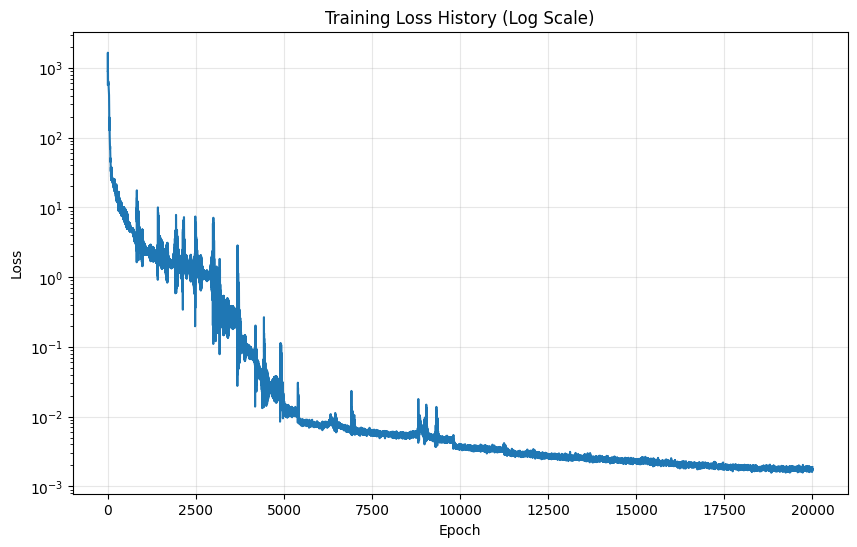


Results saved:
- improved_biharmonic_model.pt: Trained model weights
- solutions_comparison.png: 2D comparison plot
- 3d_solutions.png: 3D surface plots
- loss_history.png: Training dynamics
- loss_history.pkl: Loss history data


In [12]:
# ===================================
# Cell 11: Plot Loss History
# ===================================
plt.figure(figsize=(10, 6))
plt.semilogy(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History (Log Scale)')
plt.grid(True, alpha=0.3)
plt.savefig("loss_history.png", dpi=300, bbox_inches='tight')
plt.show()

# Save loss history
with open("loss_history.pkl", "wb") as f:
    pickle.dump(losses, f)

print(f"\nResults saved:")
print("- improved_biharmonic_model.pt: Trained model weights")
print("- solutions_comparison.png: 2D comparison plot")
print("- 3d_solutions.png: 3D surface plots")
print("- loss_history.png: Training dynamics")
print("- loss_history.pkl: Loss history data")